In [1]:
%reload_ext autoreload
import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules

from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter
from hadamard_bench import *
from pyquil import get_qc
from quil_utils import *

import json
import pandas as pd
import seaborn as sns

from Noise_siumulators import simulate_noise_aspen_m_2,simulate_noise_ion_q_11

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

#############################
Device name:  Aspen-M-2
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2
Device provider: Rigetti
Device status: ONLINE
Device availability:  False
Device region:  us-west-1
Supported gates:  ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']


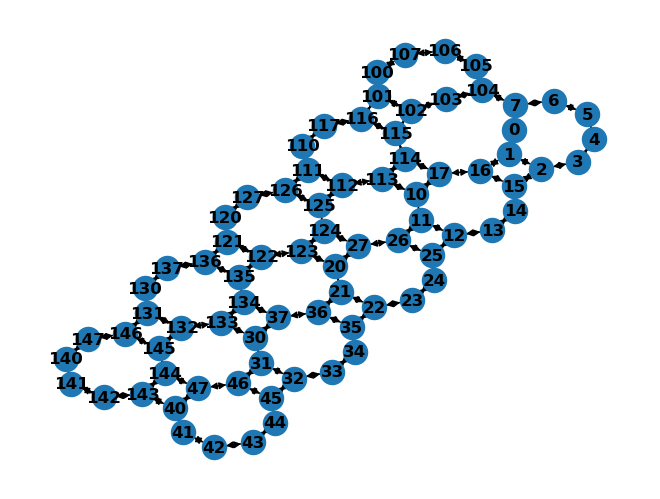

In [3]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
# rigetti = LocalSimulator()
#ion_q = LocalSimulator()

ds = DeviceScanner( device = rigetti)

ds.list_properties()

In [4]:
shots = 10_000
#set_n_qubits = range(3,10)
n_qubits = 11
set_line_length = [10,20,30,50,100]
print(set_line_length)

[10, 20, 30, 50, 100]


1000 shots 11 qubits tasks Rigetti


In [21]:
rigetti_tasks = []
labels = []

for line_length in set_line_length:
    print(line_length)
    
    circ = Circuit().H_line(n_qubits,line_length,'Rigetti')
    circ = Circuit().add_verbatim_box(circ)
   
    rigetti_task = rigetti.run(circ,shots=shots,disable_qubit_rewiring=True)
    rigetti_tasks.append(rigetti_task)
    labels.append( "rigetti_s10000_q11_hl" + str(line_length))

10
20
30
50
100


In [22]:
dump_tasks(rigetti_tasks, labels, filename = "H_line_rigetti_grosso10k")

In [5]:
tasks = load_tasks("Task_files/H_line_rigetti_grosso10k")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


1000 shots 11 qubits tasks IonQ

In [ ]:
ionq_tasks = []
labels = []

for line_length in set_line_length:
    print(line_length)
    
    circ = Circuit().H_line(n_qubits,line_length,'IonQ')
    circ = Circuit().add_verbatim_box(circ)
   
    ionq_task = ion_q.run(circ,shots=shots)
    ionq_tasks.append(ionq_task)
    labels.append( "ionq_s1000_q11_hl" + str(line_length))

In [ ]:
dump_tasks(ionq_tasks, labels, filename = "H_line_ionq_grosso")

In [6]:
ionq_tasks = load_tasks("H_line_ionq_grosso")
ion_qscanners = [BraketTaskScanner(qtask = task) for key, task in ionq_tasks.items()]

status = [task.get_status() for task in ion_qscanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


## Analisi Risultati


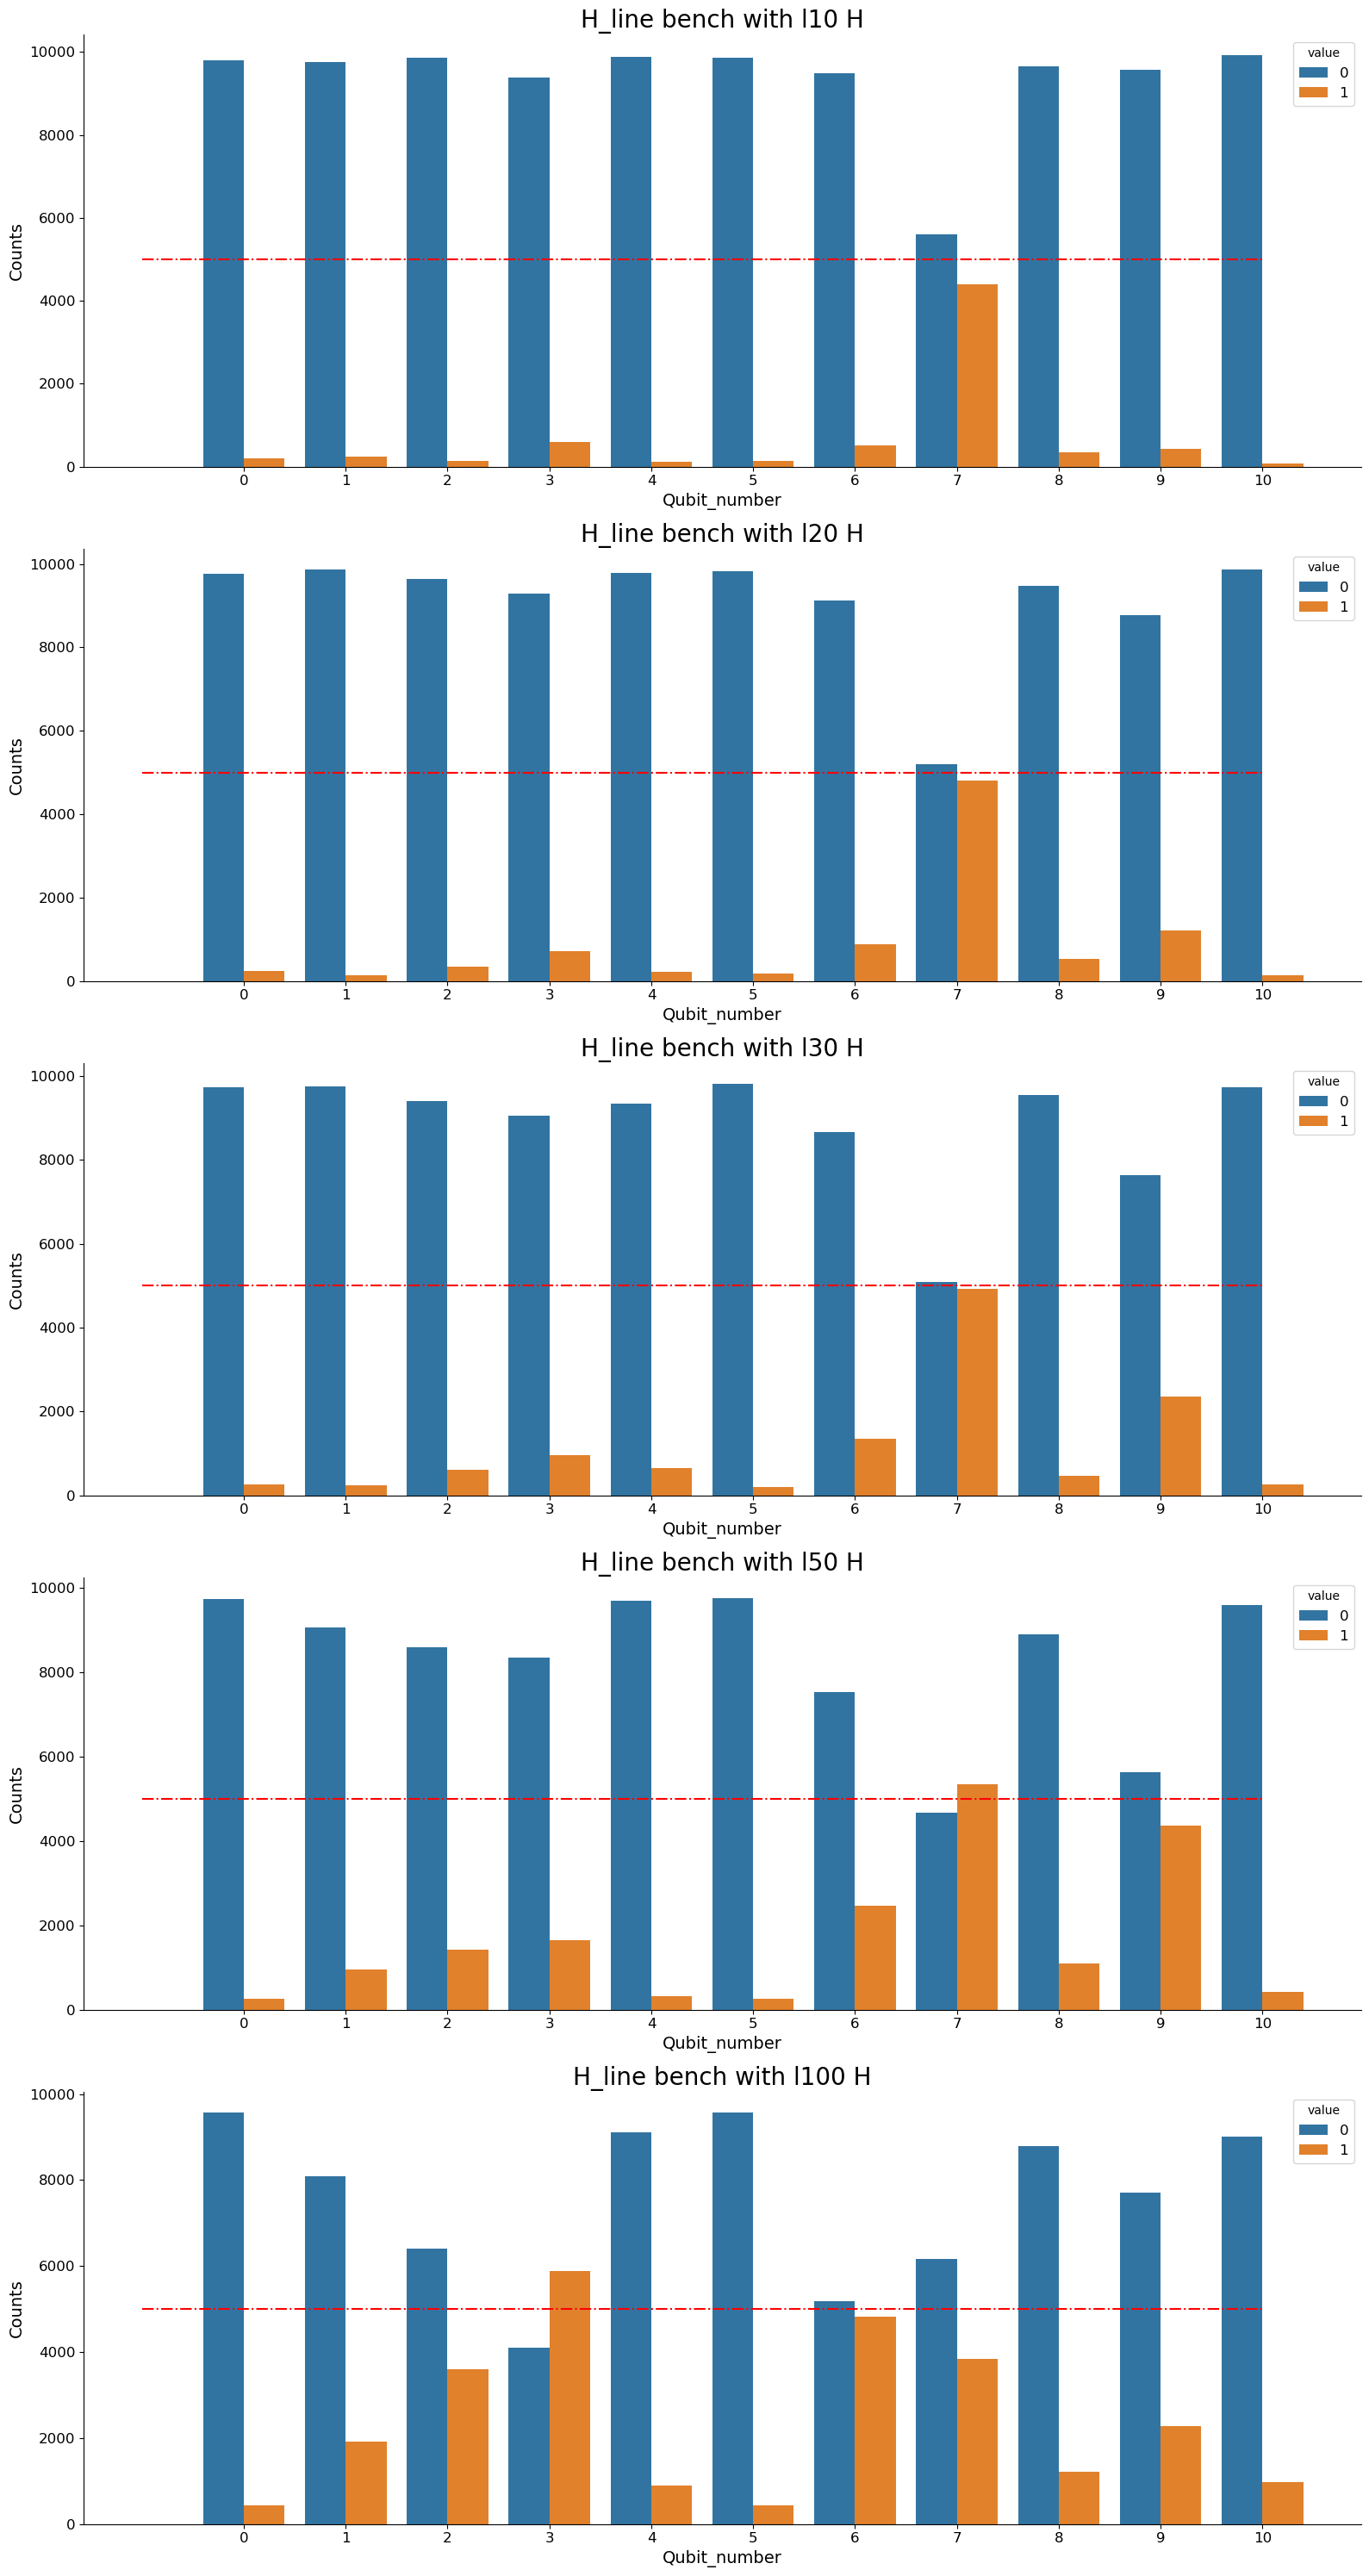

In [24]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30),tight_layout=True,)
axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,tasks):

    H_len = key.split("_")[-1][1:]
    df = result_per_qubit( tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    ax.set_title(f'H_line bench with {H_len} H',size = 20)
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')

In [16]:
qubit_mappings = [get_rigetti_compilation_map(scanner.get_compiled_circuit()) for scanner in scanners]

{'rigetti_s10000_q11_hl10': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/62e30692-0f9e-4157-b36d-09f7621a9c19'), 'rigetti_s10000_q11_hl20': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/bbd87cfa-9882-4ef3-ad30-af01c7f6e373'), 'rigetti_s10000_q11_hl30': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/5ac79b91-150e-43c1-8679-44df34441a58'), 'rigetti_s10000_q11_hl50': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/b926b2ab-bd4a-4b98-bcce-83ff5c6b9c0f'), 'rigetti_s10000_q11_hl100': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:058017682654:quantum-task/392416c6-a615-46ad-b802-44d7d737fdfb')}


[Text(0, 0, '7'),
 Text(0, 0, '17'),
 Text(0, 0, '24'),
 Text(0, 0, '31'),
 Text(0, 0, '43'),
 Text(0, 0, '100'),
 Text(0, 0, '105'),
 Text(0, 0, '111'),
 Text(0, 0, '121'),
 Text(0, 0, '135'),
 Text(0, 0, '136')]

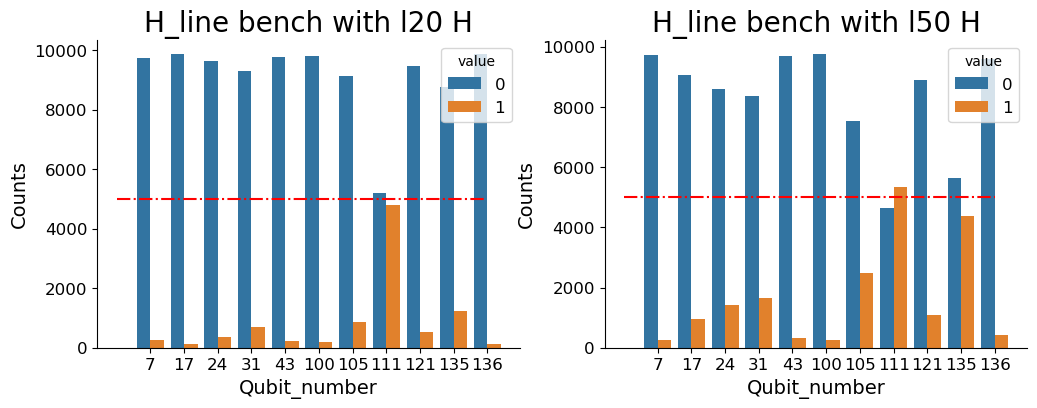

In [17]:
#for the pdf

print(tasks)

key1 = "rigetti_s10000_q11_hl20"
key2 = "rigetti_s10000_q11_hl50"

n_tasks = len(scanners)

fig, axx = plt.subplots(1,2, figsize = (12,4))

H_len = key1.split("_")[-1][1:]
df = result_per_qubit( tasks[key1].result(), H_len= H_len)
plot_result_per_qubit(data = df, ax = axx[0])
axx[0].set_title(f'H_line Rigetti with {H_len} H',size = 20)
axx[0].hlines(shots /2 ,-1,10,linestyles='-.',color='red')
axx[0].set_xticklabels([qubit_mappings[1][x] for x in range(n_qubits)])

H_len = key2.split("_")[-1][1:]
df = result_per_qubit( tasks[key2].result(), H_len= H_len)
plot_result_per_qubit(data = df, ax = axx[1])
axx[1].set_title(f'H_line Rigetti with {H_len} H',size = 20)
axx[1].hlines(shots /2 ,-1,10,linestyles='-.',color='red')
axx[1].set_xticklabels([qubit_mappings[3][x] for x in range(n_qubits)])

# RIGETTI Aspen M-2

### Graphing the results

#### Per qubit

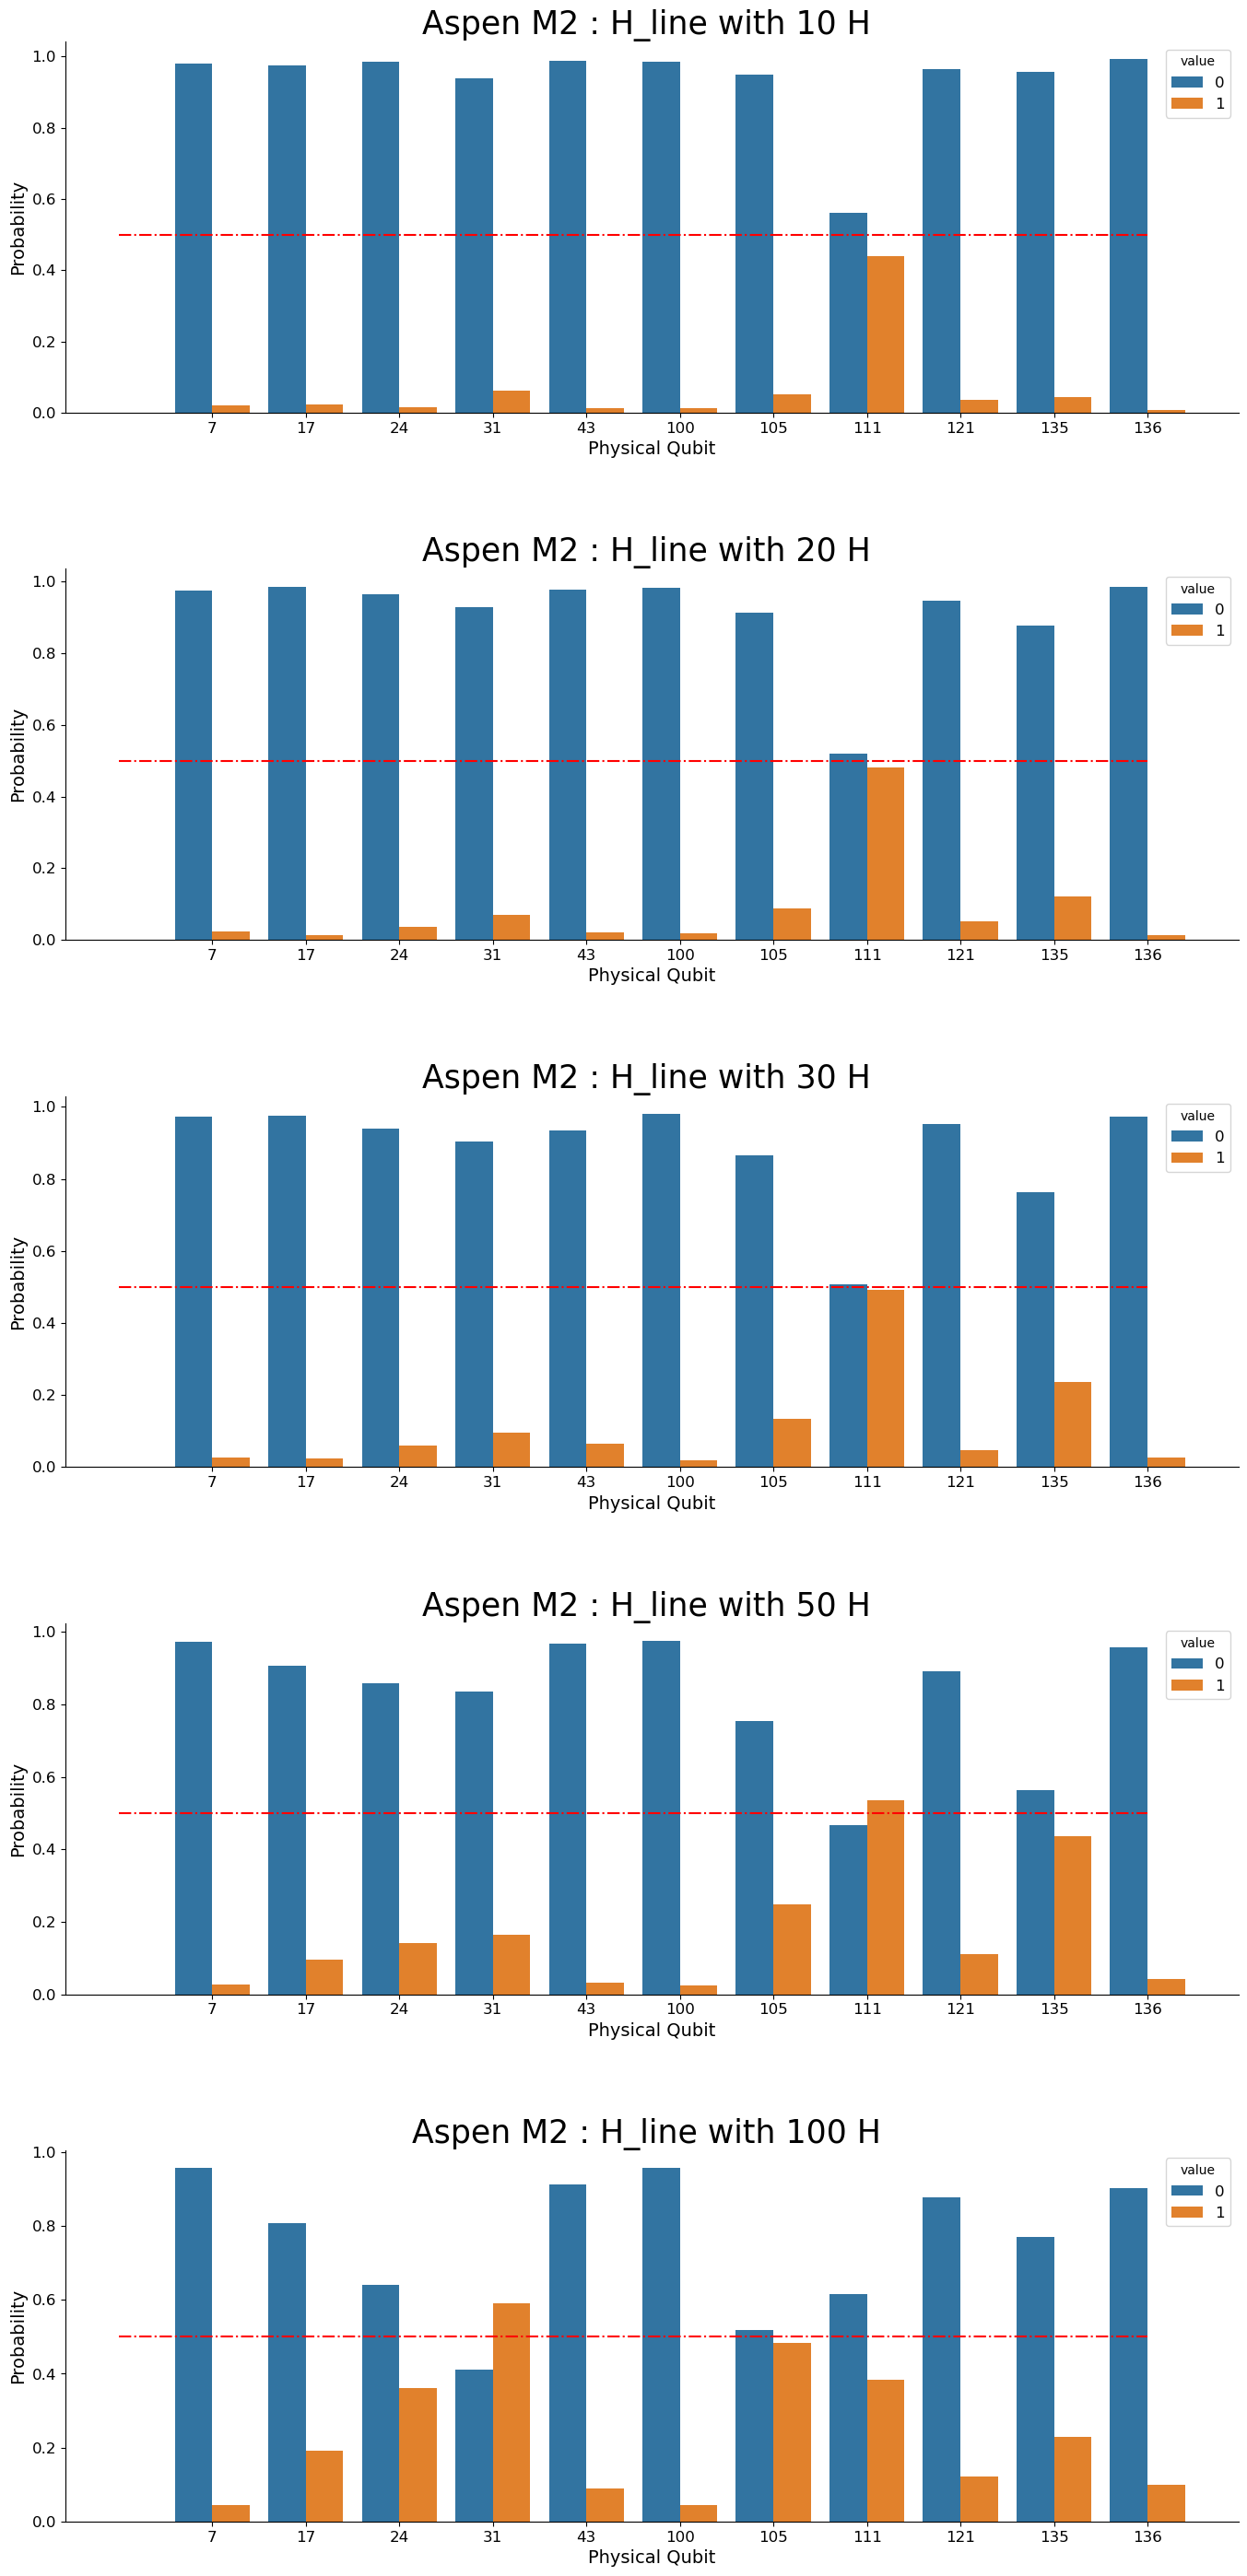

In [35]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,tasks):

    H_len = int(key.split("_")[-1][2:])

    df = result_per_qubit( tasks[key].result(), H_len= H_len)
    df.counts/=shots
    plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'Aspen M2 : H_line with {H_len} H ',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.set_ylabel('Probability')
    ax.hlines(1 /2 ,-1,10,linestyles='-.',color='red')
    ax.set_xticklabels([qubit_mappings[i][x] for x in range(n_qubits)])
    i+=1

#### Error rate analysis

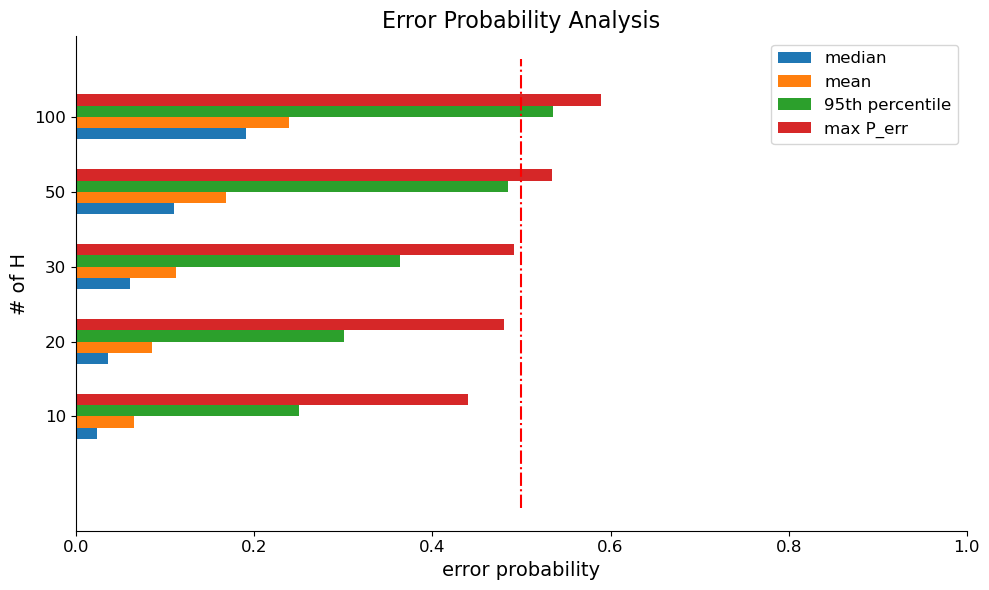

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(10,6),tight_layout=True,)
p_err = []
max_err = []
data_dict =[]
median_err=[]
quantile_95=[]
for key in tasks:
    #building dataframe
    H_len = int(key.split("_")[-1][2:])
    df = result_per_qubit( tasks[key].result(), H_len= H_len)
    
    #saving important data

    p_err.append((df.counts[df.value=='1']/shots).mean())
    max_err.append(df.counts[df.value=='1'].max()/shots)
    median_err.append(df.counts[df.value=='1'].median()/shots)
    quantile_95.append(df.counts[df.value=='1'].quantile(.95)/shots)
    
    
bar_width = .15
x = np.arange(len(set_line_length))

b1= ax.barh(x, median_err,
            height=bar_width,
           label = 'median')


b2 = ax.barh(x+bar_width, p_err,
            height=bar_width,label = 'mean')


b3= ax.barh(x+2*bar_width, quantile_95,
            height=bar_width,
           label = '95th percentile')

b4 = ax.barh(x+3*bar_width, max_err,
            height=bar_width,
           label = 'max P_err')


ax.set_yticks(x + bar_width*1.5 )
ax.set_yticklabels(set_line_length)
ax.set_title('Error Probability Analysis')
ax.set_xlabel('error probability')
ax.set_ylabel('# of H')
ax.set_xlim(0,1)
ax.vlines(0.5,x[0]-1,x[-1]+1,linestyles='-.',color='red')
ax.legend()

In [94]:
p_err

[0.0189,
 0.1213,
 0.2127,
 0.017,
 0.1297,
 0.2254,
 0.0171,
 0.1262,
 0.2232,
 0.0169,
 0.1328,
 0.2359]

#### worst qubit analysis

In [43]:
shots = 10_000
worst_qubits = [24,31,105,111]
set_line_length_worst = [20,100,500]

In [37]:
rigetti_tasks = []
labels = []

for qubit_n in worst_qubits:
    for line_length in set_line_length:
        print(line_length)

        circ = Circuit().H_line([qubit_n],line_length,'Rigetti')
        circ = Circuit().add_verbatim_box(circ)

        rigetti_task = rigetti.run(circ,shots=shots,disable_qubit_rewiring=True)
        rigetti_tasks.append(rigetti_task)
        labels.append( "rigetti_s10000_q" + str(qubit_n)+"_hl" + str(line_length))
        

20
100
500
20
100
500
20
100
500
20
100
500


In [38]:
dump_tasks(rigetti_tasks, labels, filename = "H_line_rigetti_schifo_10k.json")

In [39]:
tasks = load_tasks("H_line_rigetti_schifo_10k.json")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


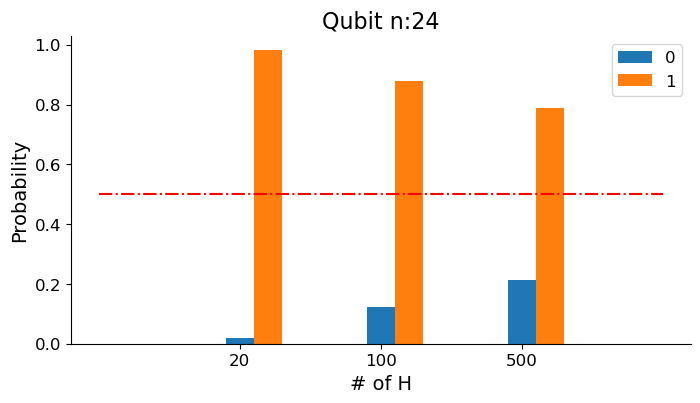

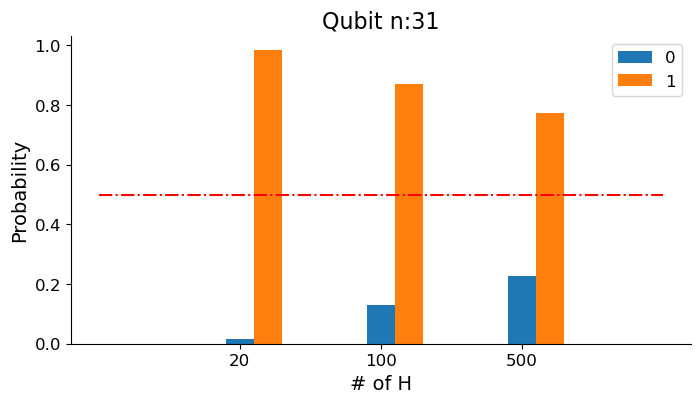

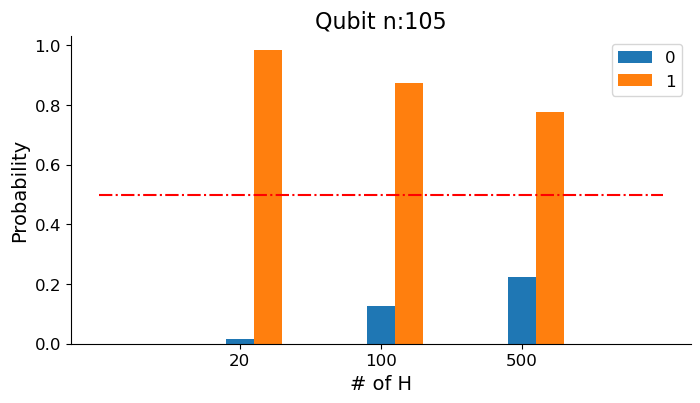

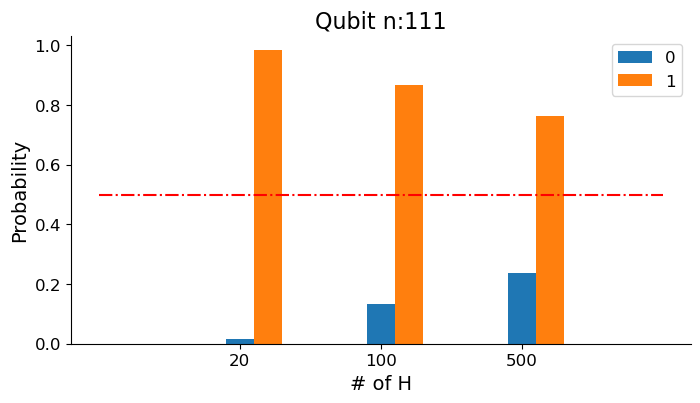

In [81]:

bar_width = .2
x_axis = np.arange(len(set_line_length_worst))

for i,qubit_n in enumerate(worst_qubits):
    fig,ax = plt.subplots(1, 1, figsize=(8, 4))  
    p_0=[]
    p_1=[]
    for j,line_length in enumerate(set_line_length_worst):
        
        #getting result by scanners
        results = scanners[i*len(set_line_length_worst) + j].get_results()
        counts = results.measurement_counts
        p_0.append(counts['0']/shots)
        p_1.append(counts['1']/shots)
        
    #plot
    ax.bar(x_axis,
           p_1,   
           width=bar_width,
           label = '0')
    ax.bar(x_axis + bar_width,
          p_0,
          width=bar_width,
          label='1')
    
    ax.set_title(f'Qubit n:{qubit_n}')
    ax.set_xlabel('# of H')
    ax.set_ylabel('Probability')
    ax.set_xticks(x_axis)
    ax.set_xticklabels([str(x) for x in set_line_length_worst])
    ax.hlines(1 /2 ,x_axis[0]-1,x_axis[-1]+1,linestyles='-.',color='red')
    ax.legend()

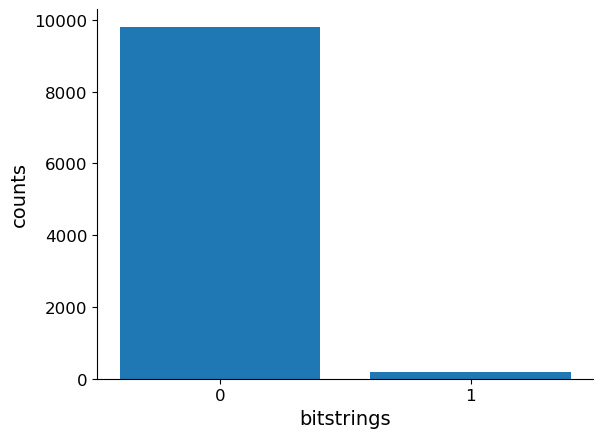

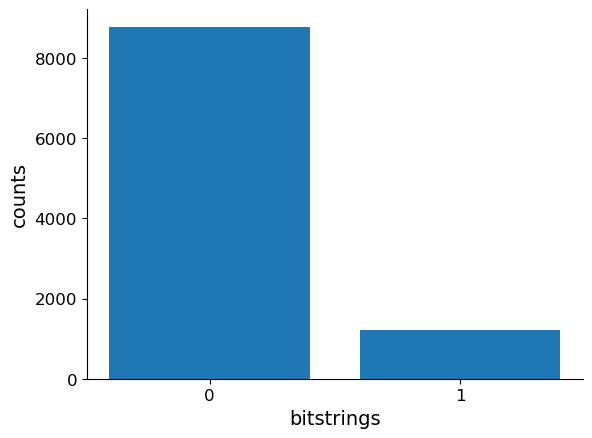

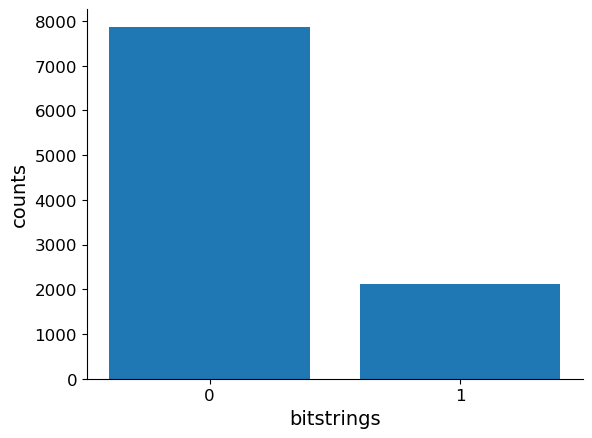

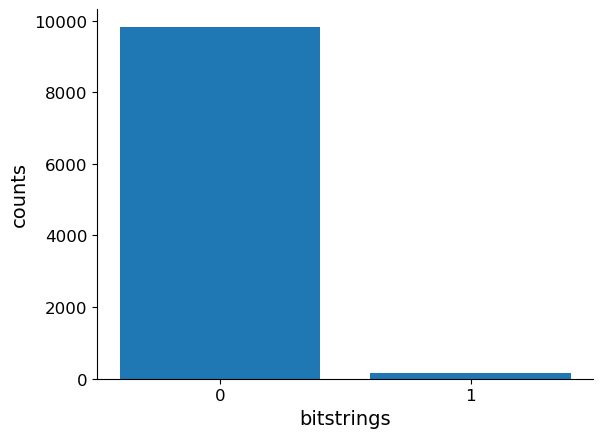

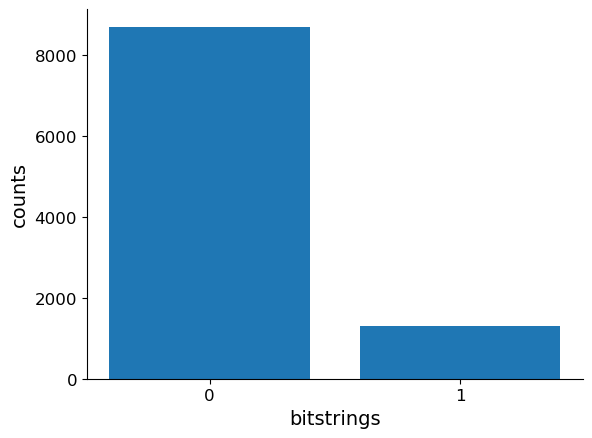

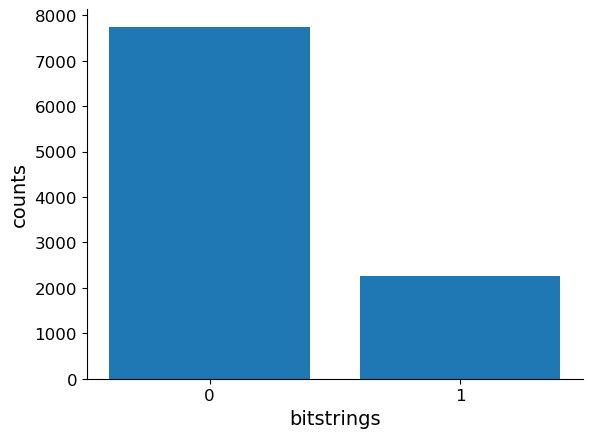

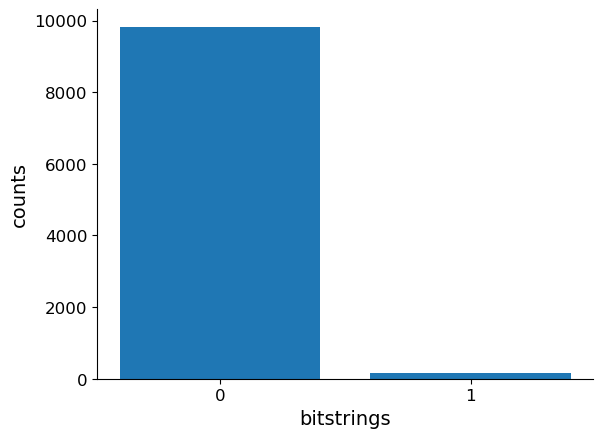

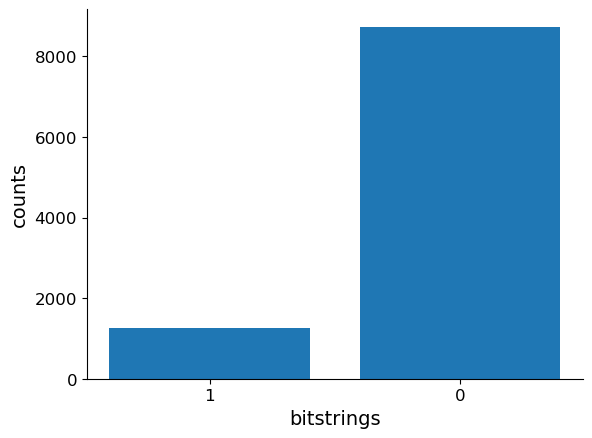

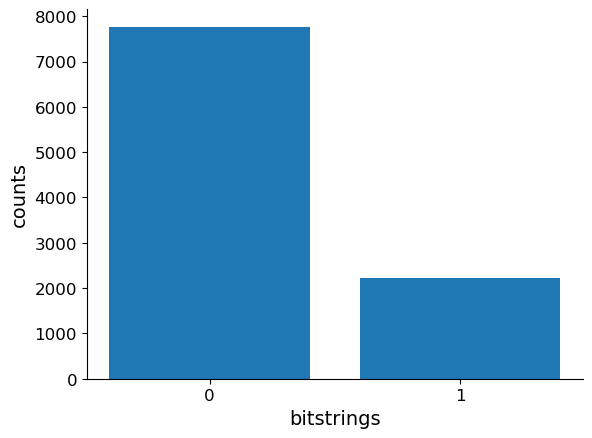

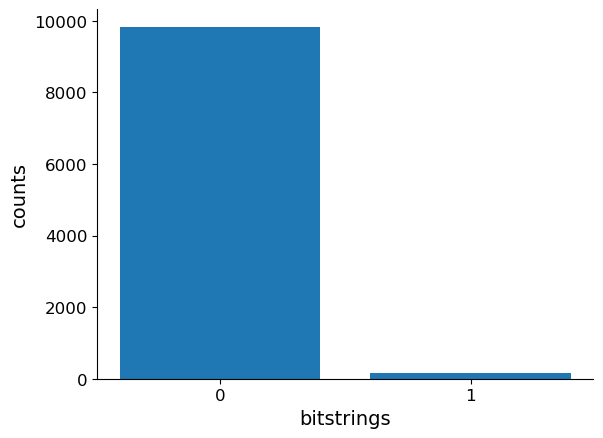

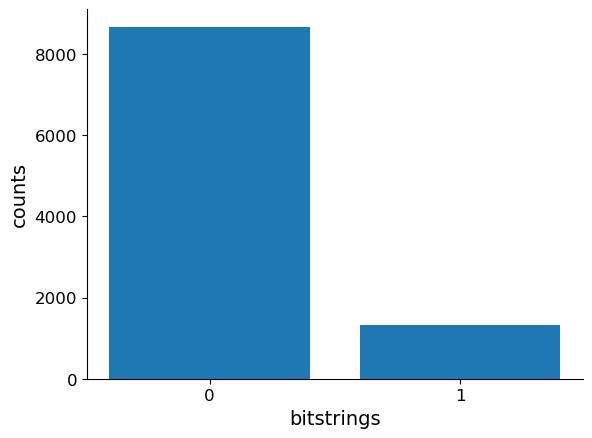

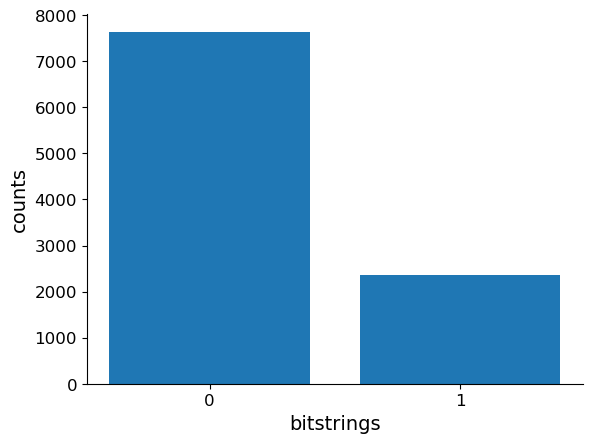

In [40]:
axx = []
for scanner in scanners:
    axx.append(Plotter.plot_binary_results(scanner.get_results()))

# IONQ


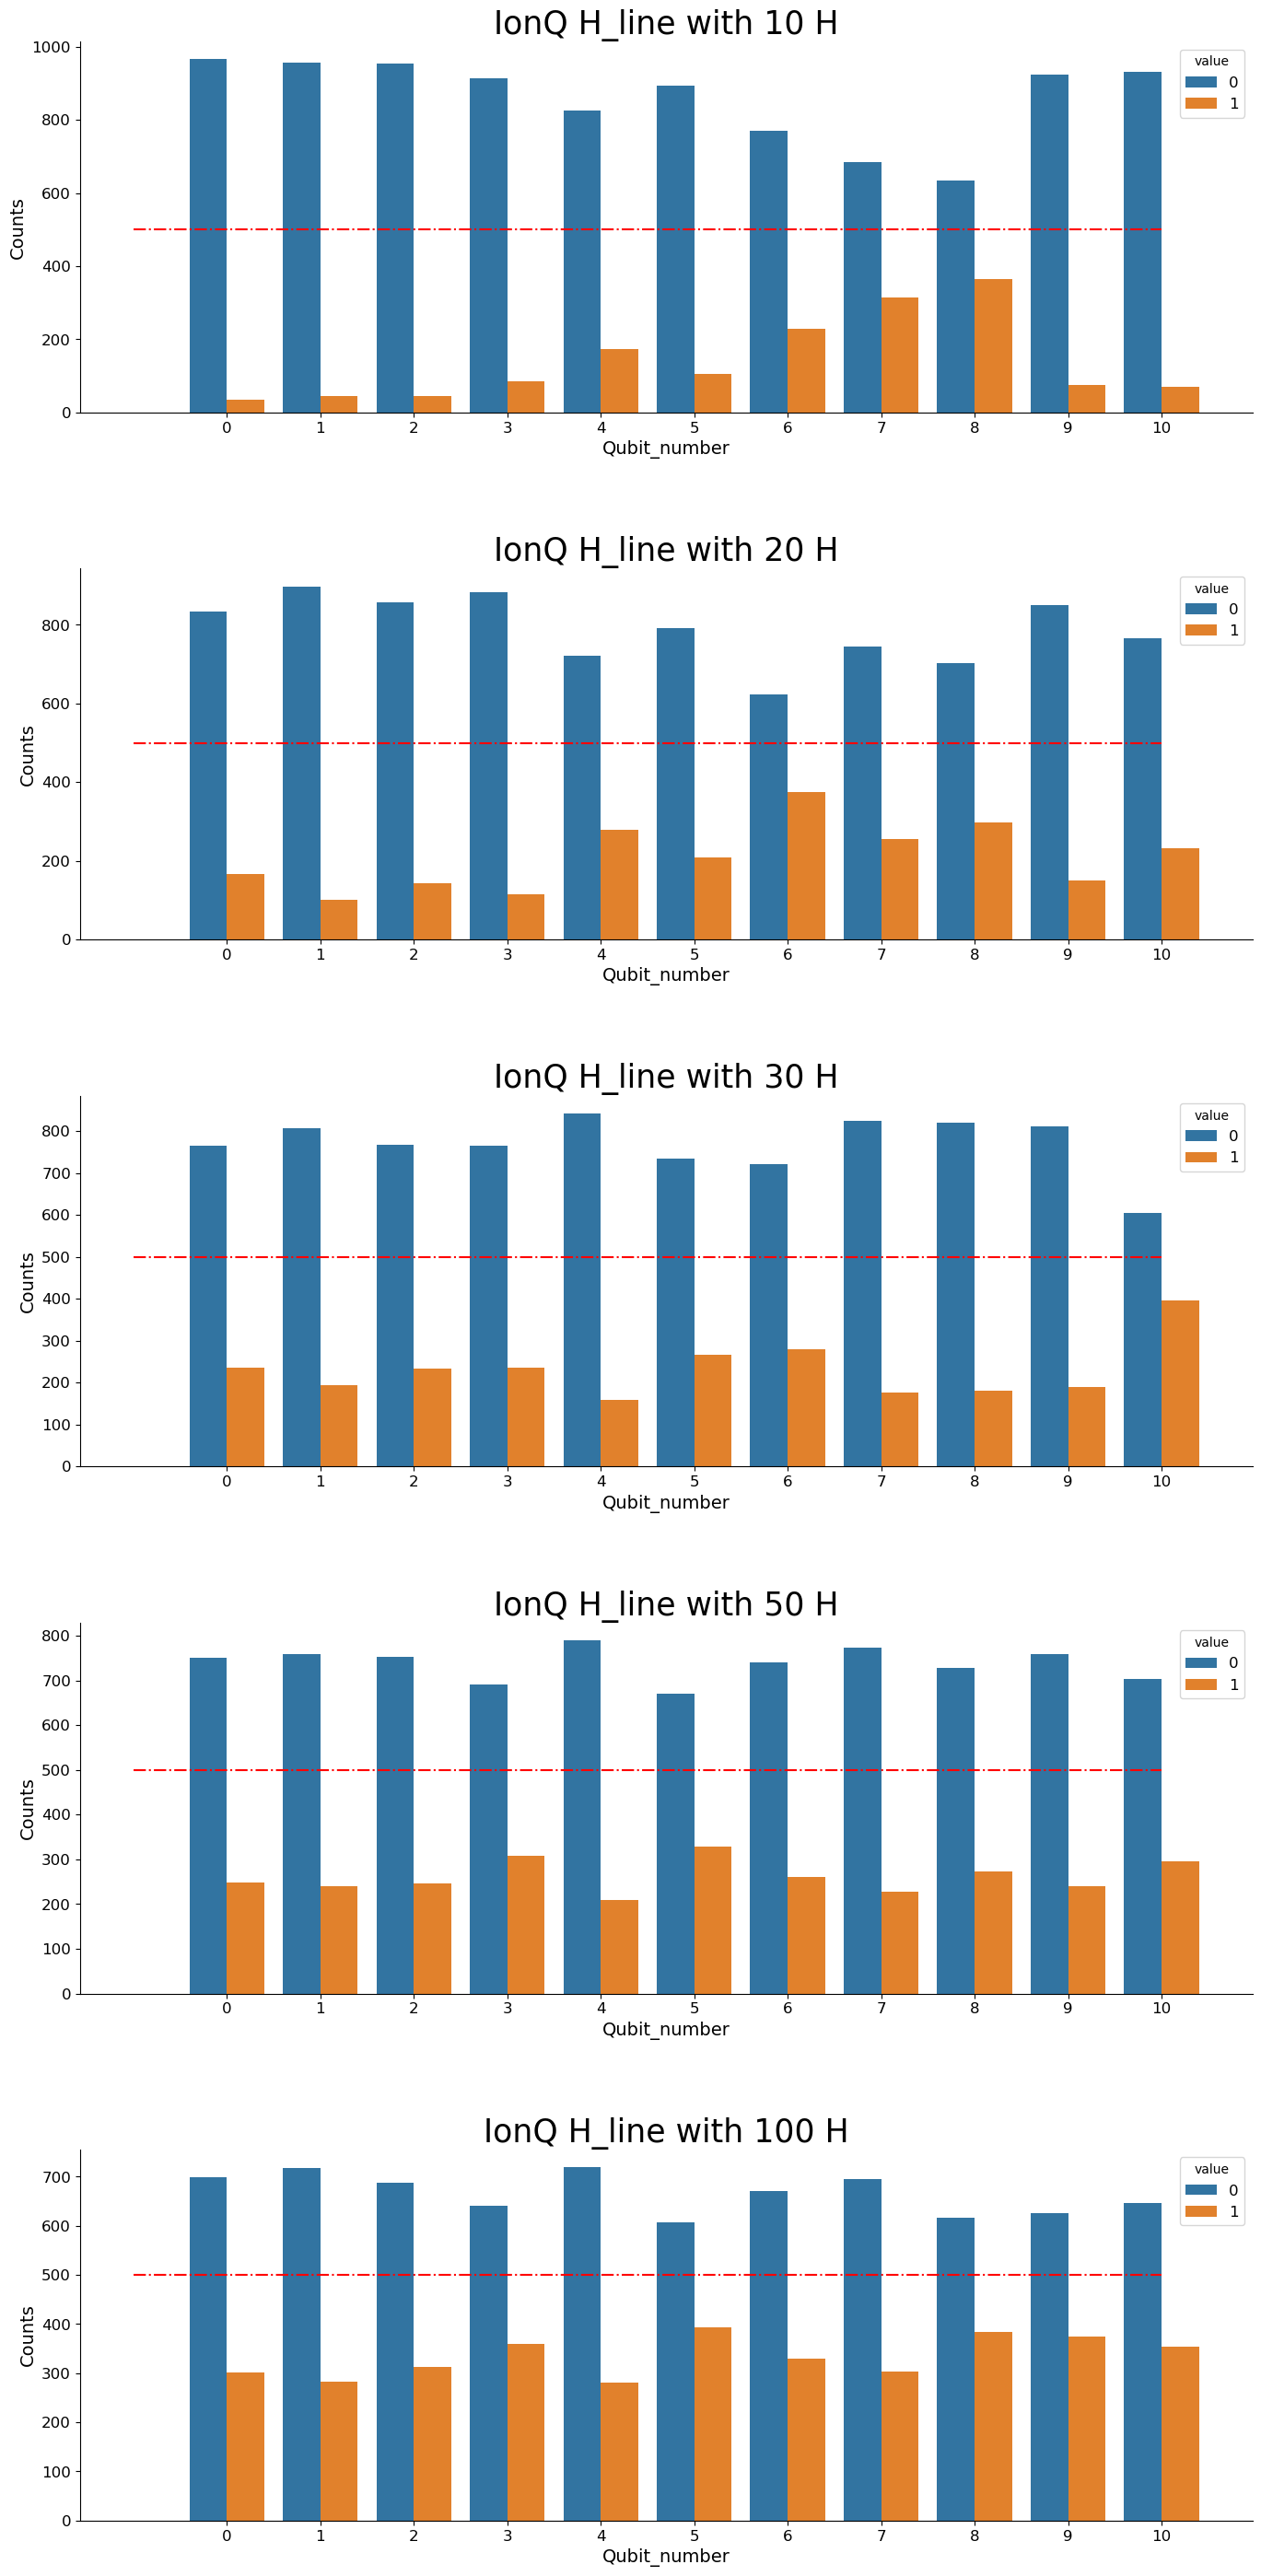

In [9]:
n_tasks = len(ion_qscanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30))
fig.tight_layout(pad=10.0)


axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,ionq_tasks):

    H_len = int(key.split("_")[-1][2:])
    df = result_per_qubit( ionq_tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    ax.set_title(f'IonQ H_line with {H_len} H',size=25)
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')

{'ionq_s1000_q11_hl10': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/a7f2f1c0-213d-4d55-a12e-0c59c9f960d2'), 'ionq_s1000_q11_hl20': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/8131729d-71bc-4c1b-9557-8c0add73269c'), 'ionq_s1000_q11_hl30': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/f8034bc8-8788-44c9-ac19-b6a7fa152d49'), 'ionq_s1000_q11_hl50': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/1db588ba-9c8d-403d-bffb-fe81ccc346af'), 'ionq_s1000_q11_hl100': AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:058017682654:quantum-task/812dd426-7100-484e-aee6-40e837b4bcba')}


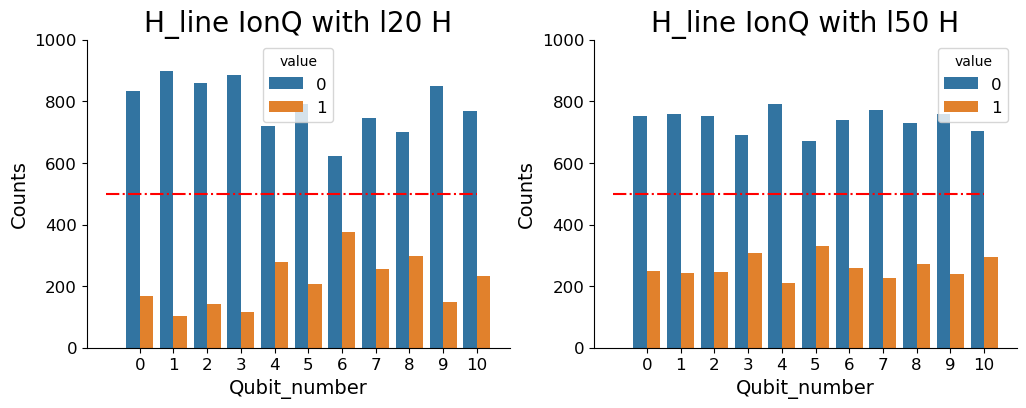

In [22]:
#for the pdf

print(ionq_tasks)

key1 = "ionq_s1000_q11_hl20"
key2 = "ionq_s1000_q11_hl50"
shots = 1000

n_tasks = len(scanners)

fig, axx = plt.subplots(1,2, figsize = (12,4))
axx[0].set_ylim(0,shots)
axx[1].set_ylim(0,shots)

H_len = key1.split("_")[-1][1:]
df = result_per_qubit( ionq_tasks[key1].result(), H_len= H_len)
plot_result_per_qubit(data = df, ax = axx[0])
axx[0].set_title(f'H_line IonQ with {H_len} H',size = 20)
axx[0].hlines(shots /2 ,-1,10,linestyles='-.',color='red')

H_len = key2.split("_")[-1][1:]
df = result_per_qubit( ionq_tasks[key2].result(), H_len= H_len)
plot_result_per_qubit(data = df, ax = axx[1])
axx[1].set_title(f'H_line IonQ with {H_len} H',size = 20)
axx[1].hlines(shots /2 ,-1,10,linestyles='-.',color='red')

# Confronto con le simulazioni

In [10]:
rigetti_tasks = load_tasks("H_line_rigetti_grosso")
rigetti_scanners = [BraketTaskScanner(qtask = task) for key, task in rigetti_tasks.items()]
ls_tasks = load_tasks("H_line_l_s_grosso.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]


In [11]:
tasks = load_tasks("H_line_rigetti_grosso")
scanners = [BraketTaskScanner(qtask = task) for key, task in tasks.items()]

status = [task.get_status() for task in scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [12]:
local_simulator = DeviceUtils.get_device('dm1')

In [ ]:
circuits =[Quil_to_Braket_Transpiler(scanner.get_compiled_circuit(),quil_rewiring=True).braket_circ for scanner in scanners]
simulation_tasks = []
labels = []
qubit_mappings_sim = []
for i,line_length in enumerate(set_line_length):
    print(line_length)
    
    circ = circuits[i]
    noisy_circ,qubit_mapping = simulate_noise_aspen_m_2(circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=10_000)
    
    simulation_tasks.append(simulation_task)
    qubit_mappings_sim.append(qubit_mapping)
    labels.append( "ls_rigetti_s1000_q11_hl_" + str(line_length))

In [ ]:
dump_tasks(simulation_tasks, labels, filename = "H_line_l_s_grosso.json")

In [13]:
ls_tasks = load_tasks("H_line_l_s_grosso.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


NameError: name 'qubit_mappings_sim' is not defined

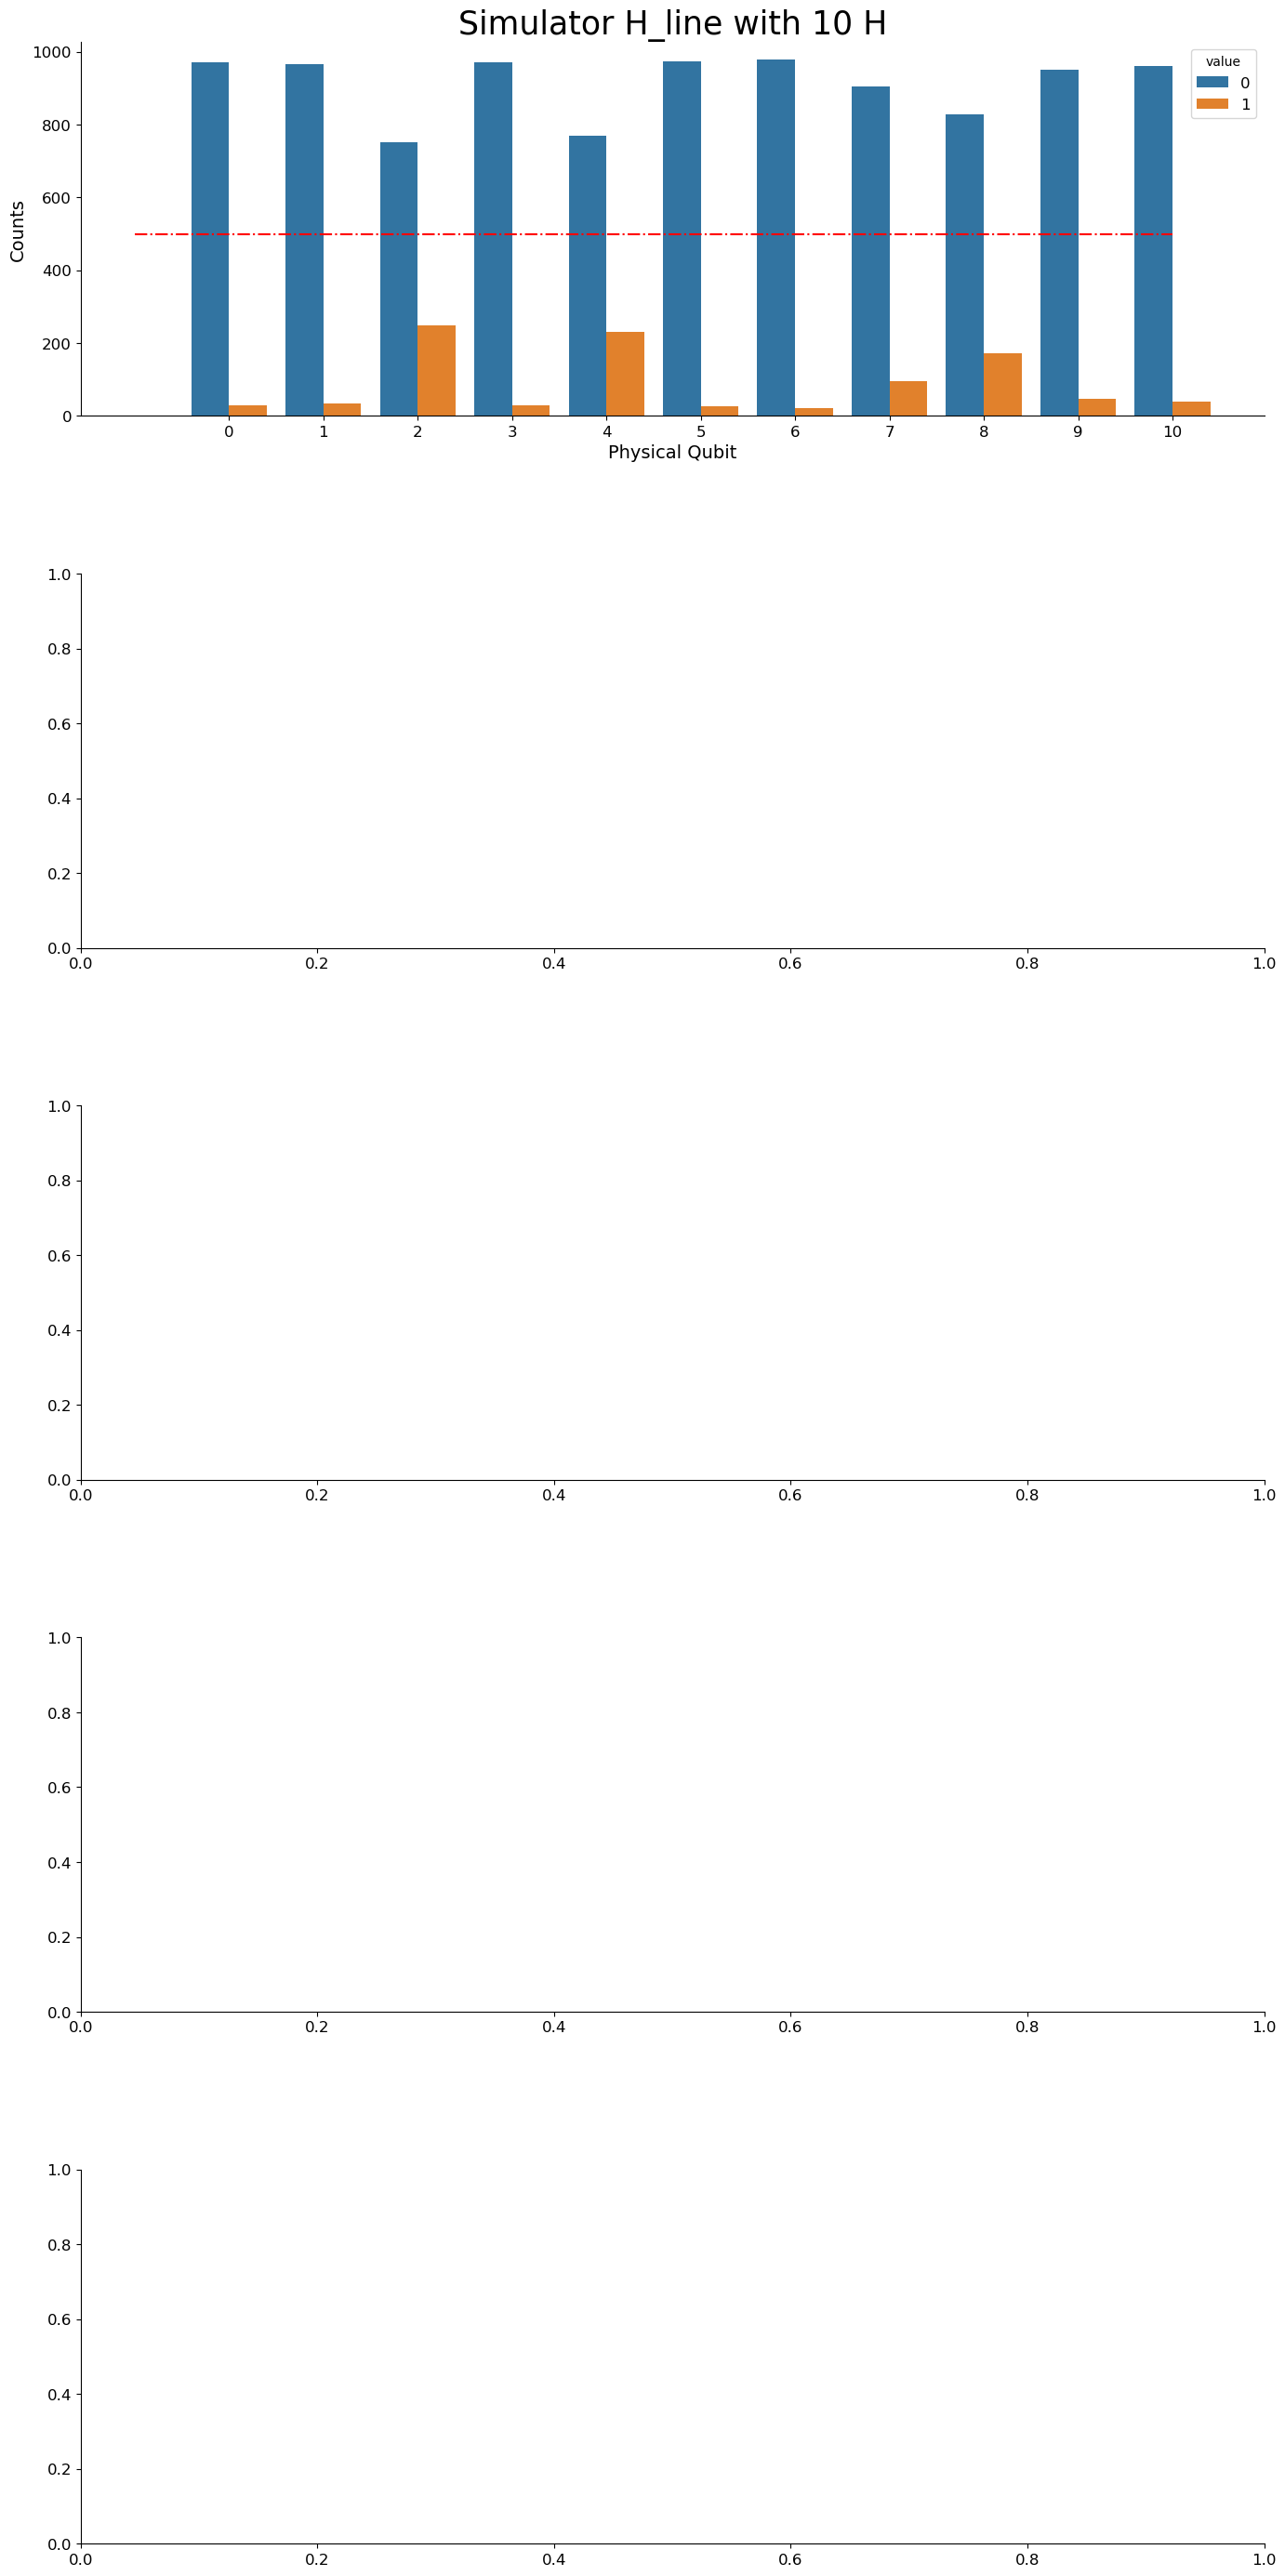

In [14]:
n_tasks = len(scanners)

fig, axx = plt.subplots(n_tasks, 1, figsize=(16, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
for ax, key in zip(axx,ls_tasks):
    H_len = key.split("_")[-1]

    df = result_per_qubit( ls_tasks[key].result(), H_len= H_len)
    plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'Simulator H_line with {H_len} H',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red')
    ax.set_xticklabels(qubit_mappings_sim[i].keys())
    i+=1

In [15]:
rigetti_tasks = load_tasks("H_line_rigetti_grosso")
rigetti_scanners = [BraketTaskScanner(qtask = task) for key, task in rigetti_tasks.items()]
ls_tasks = load_tasks("H_line_l_s_grosso.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]


# Rigetti

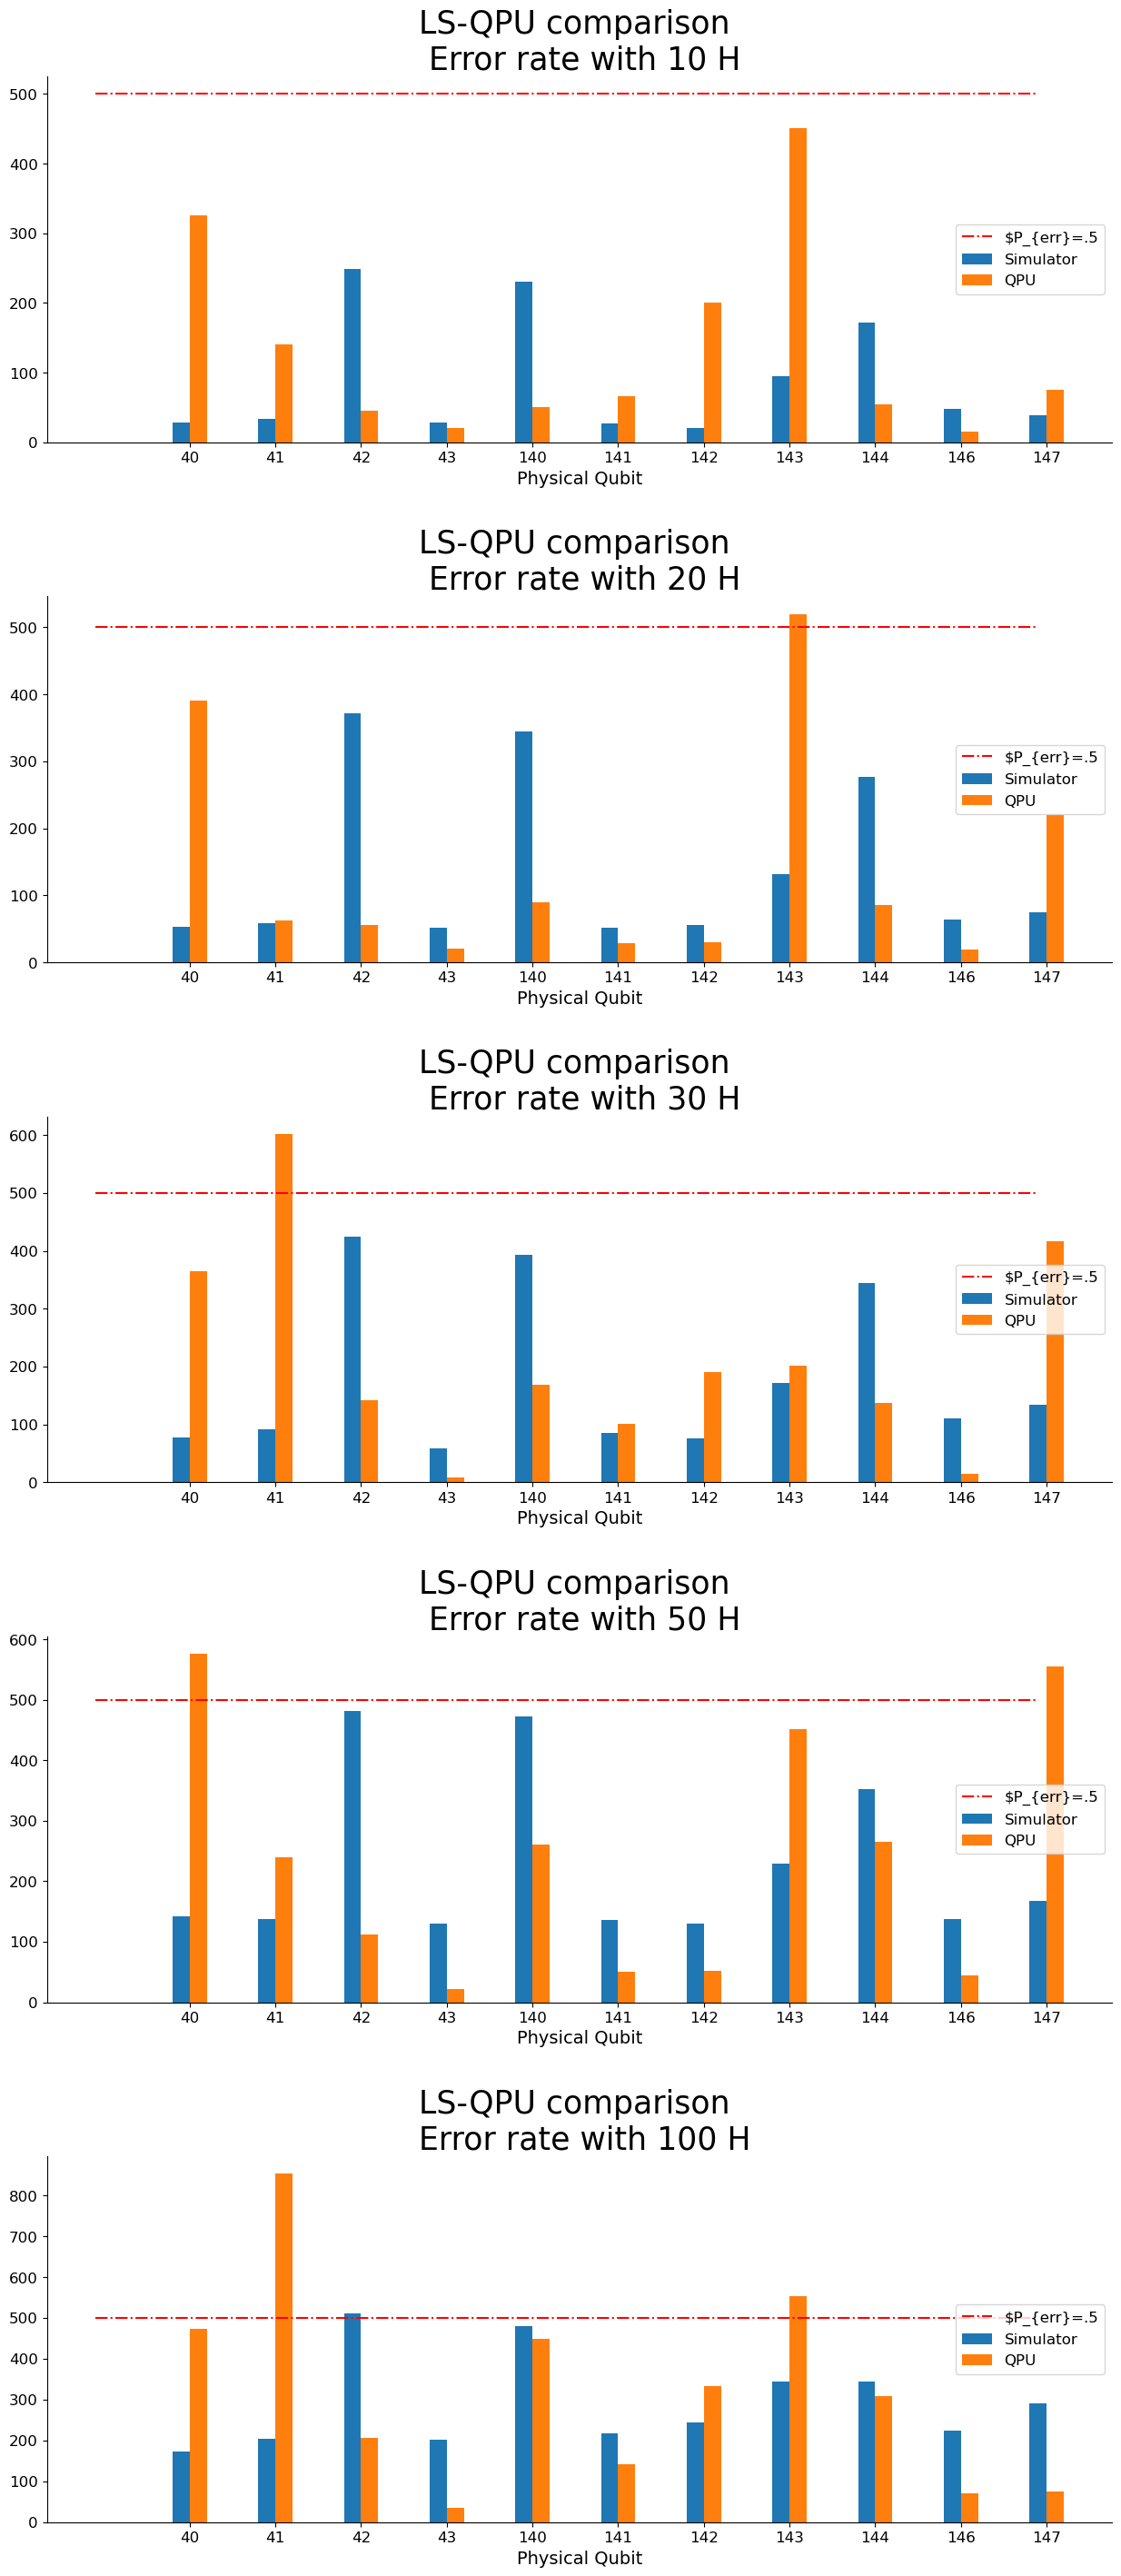

In [16]:
n_tasks = len(ls_scanners)
fig, axx = plt.subplots(n_tasks, 1, figsize=(15, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
x = np.arange(n_qubits)
bar_width = .2

for ax, rig_key,ls_key in zip(axx,rigetti_tasks,ls_tasks):

    H_len = int(rig_key.split("_")[-1][2:])

    df_sim = result_per_qubit( ls_tasks[ls_key].result(), H_len= H_len)
    df_qpu = result_per_qubit( rigetti_tasks[rig_key].result(), H_len= H_len)

    ax.bar(x, df_sim.counts[df_sim.value == '1'],
            width=bar_width,
           label = 'Simulator')
    
    ax.bar(x+bar_width, df_qpu.counts[df_qpu.value == '1'],
            width=bar_width,
           label = 'QPU')
    #plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'LS-QPU comparison \n Error rate with {H_len} H',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red',label='$P_{err}=.5')
    ax.set_xticks(x + bar_width/2 )
    ax.set_xticklabels([qubit_mappings[i][x] for x in range(n_qubits)])
    
    ax.legend(loc='center right')
    i+=1

# IONQ


In [22]:
circuits =[Circuit().H_line(n_qubits,line_length,'IonQ') for line_length in set_line_length]
simulation_tasks = []
labels = []
for i,line_length in enumerate(set_line_length):
    print(line_length)
    
    circ = circuits[i]
    noisy_circ = simulate_noise_ion_q_11 (circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=1_000)
    
    simulation_tasks.append(simulation_task)
    #qubit_mappings_sim.append(qubit_mapping)
    labels.append( "ls_rigetti_s1000_q11_hl_" + str(line_length))

10
20
30
50
100


In [23]:
dump_tasks(simulation_tasks, labels, filename = "H_line_l_s_ion_q.json")

In [24]:
ls_tasks = load_tasks("H_line_l_s_ion_q.json")
ls_scanners = [BraketTaskScanner(qtask = task) for key, task in ls_tasks.items()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'RUNNING']


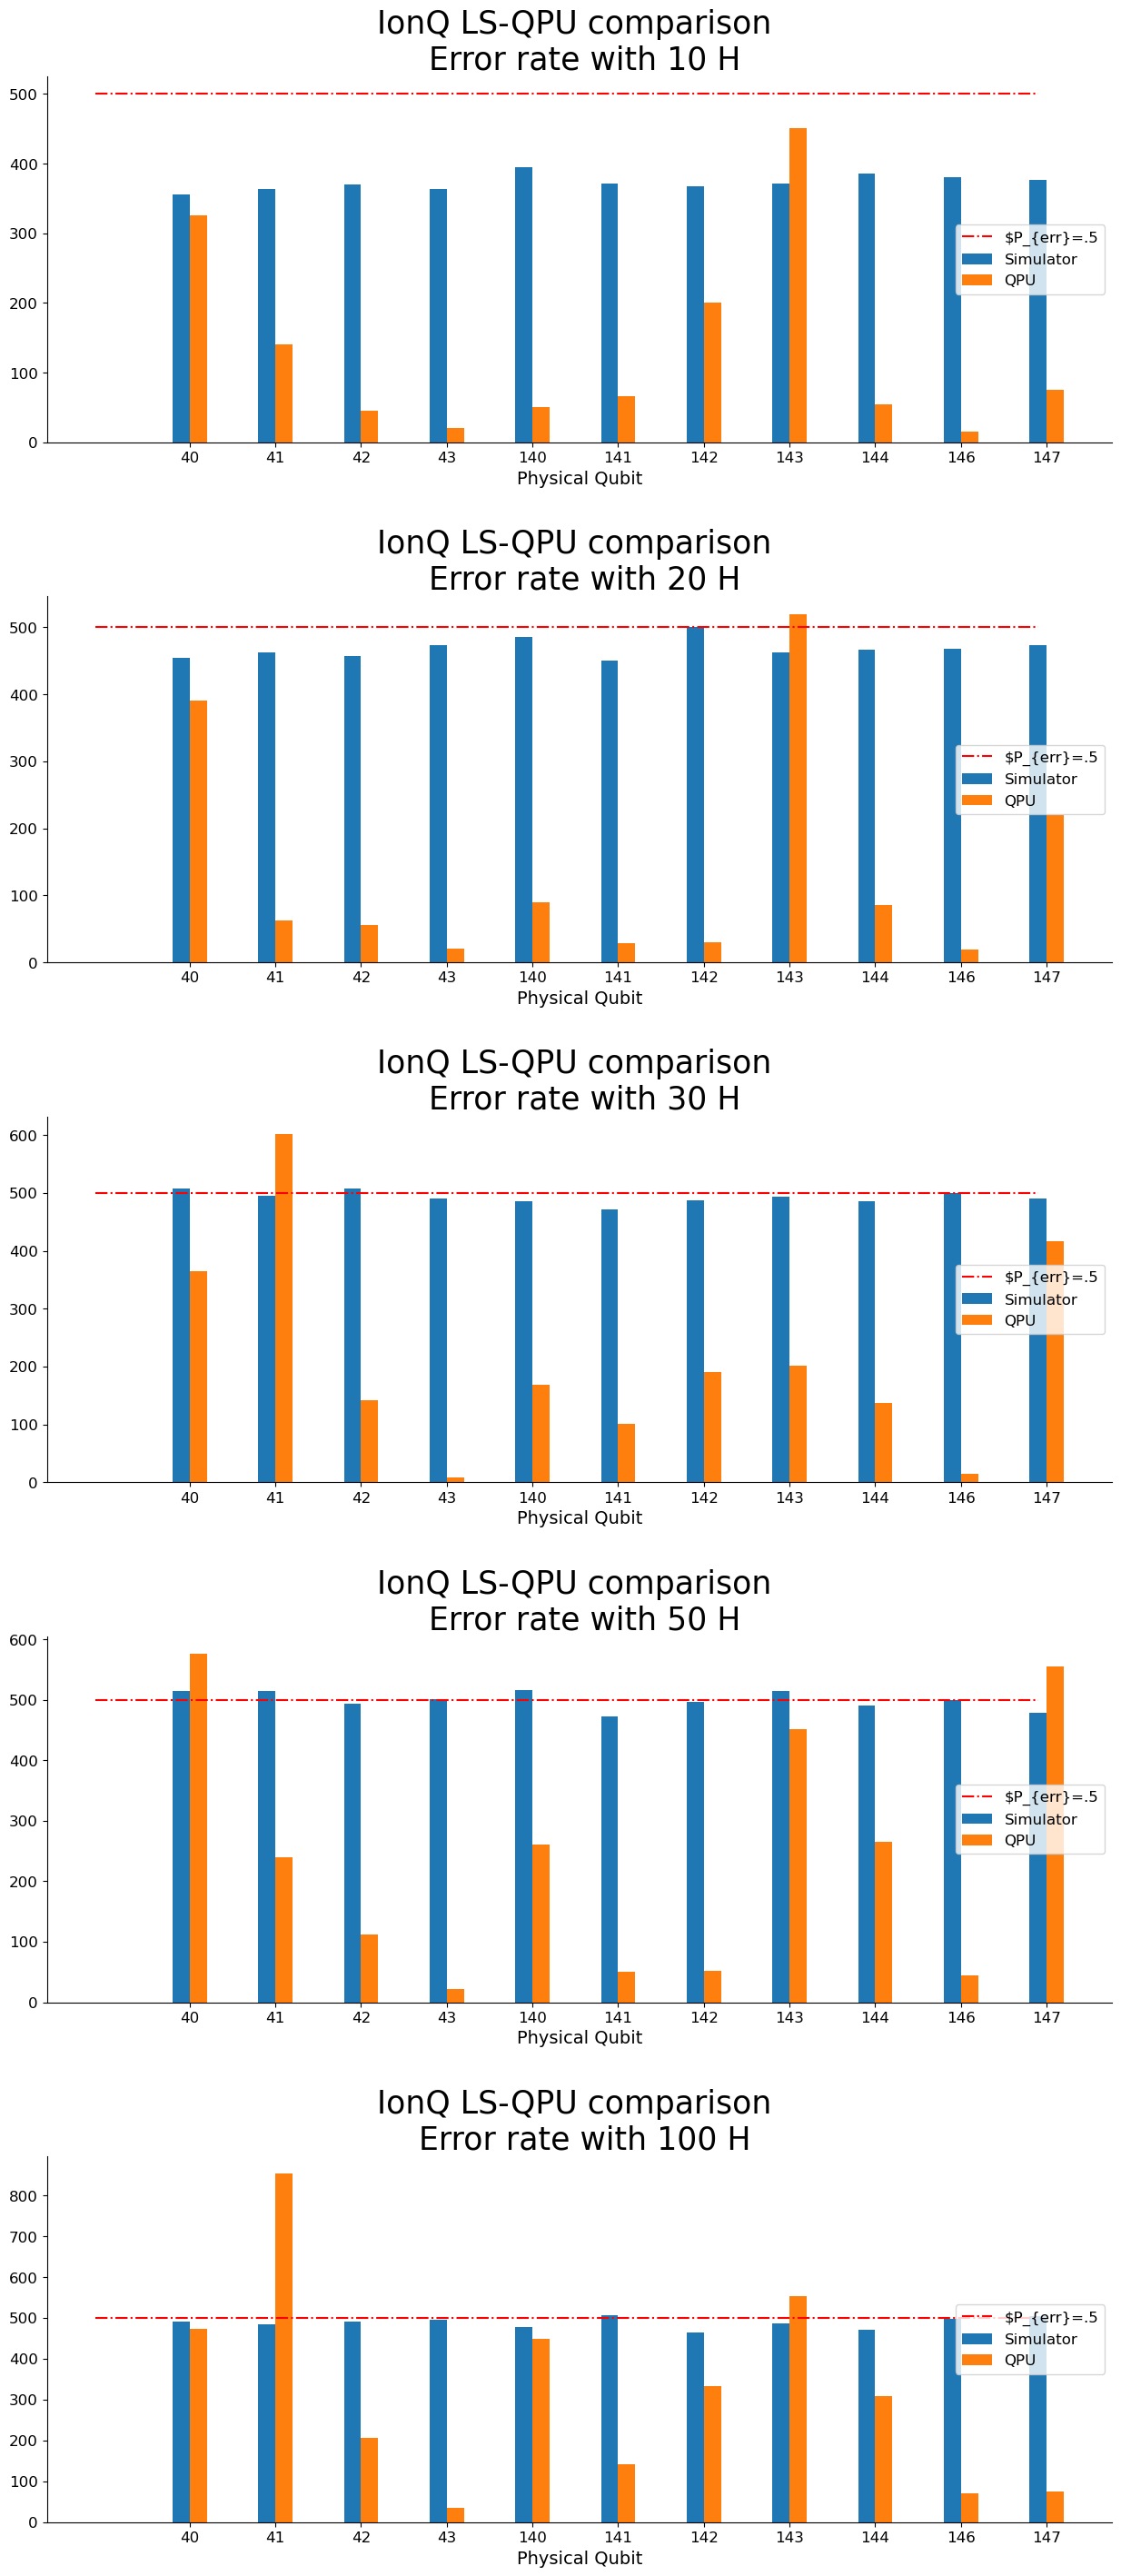

In [25]:
n_tasks = len(ls_scanners)
fig, axx = plt.subplots(n_tasks, 1, figsize=(15, 30))
fig.tight_layout(pad=10.0)

axx = axx.reshape(-1)
i=0
x = np.arange(n_qubits)
bar_width = .2

for ax, rig_key,ls_key in zip(axx,rigetti_tasks,ls_tasks):

    H_len = int(rig_key.split("_")[-1][2:])

    df_sim = result_per_qubit( ls_tasks[ls_key].result(), H_len= H_len)
    df_qpu = result_per_qubit( rigetti_tasks[rig_key].result(), H_len= H_len)

    ax.bar(x, df_sim.counts[df_sim.value == '1'],
            width=bar_width,
           label = 'Simulator')
    
    ax.bar(x+bar_width, df_qpu.counts[df_qpu.value == '1'],
            width=bar_width,
           label = 'QPU')
    #plot_result_per_qubit(data = df, ax = ax)
    
    ax.set_title(f'IonQ LS-QPU comparison \n Error rate with {H_len} H',size=25)
    ax.set_xlabel('Physical Qubit')
    ax.hlines(shots /2 ,-1,10,linestyles='-.',color='red',label='$P_{err}=.5')
    ax.set_xticks(x + bar_width/2 )
    ax.set_xticklabels([x for x in range(n_qubits)])
    
    ax.legend(loc='center right')
    i+=1